<a href="https://colab.research.google.com/github/SauloHenriqueAguiar/DeepLearningRNN/blob/main/SeriesTemporaisProdicaoLSTMPyTorchVendasShampoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predição de série temporal com LSTM usando PyTorch




## Download Dataset

In [6]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

--2021-12-01 20:51:33--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519 [text/plain]
Saving to: ‘shampoo.csv.1’

shampoo.csv.1       100%[===================>]     519  --.-KB/s    in 0s      

2021-12-01 20:51:33 (23.6 MB/s) - ‘shampoo.csv.1’ saved [519/519]



## Bibliotecas

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Visualização dos dados

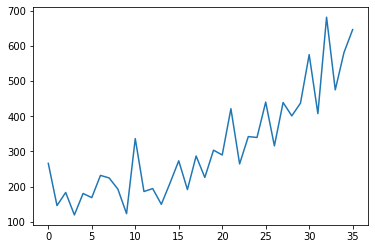

In [8]:

training_set = pd.read_csv('shampoo.csv')

training_set = training_set.iloc[:,1:2].values

plt.plot(training_set, label = 'Shampoo Sales Data')

plt.show()

## Leitura dos Dados

In [9]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Configuração de Modelo

In [10]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## Treinamento

In [11]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.01709
Epoch: 100, loss: 0.01090
Epoch: 200, loss: 0.01032
Epoch: 300, loss: 0.00910
Epoch: 400, loss: 0.00532
Epoch: 500, loss: 0.00445
Epoch: 600, loss: 0.00400
Epoch: 700, loss: 0.00349
Epoch: 800, loss: 0.00327
Epoch: 900, loss: 0.00287
Epoch: 1000, loss: 0.00269
Epoch: 1100, loss: 0.00249
Epoch: 1200, loss: 0.00231
Epoch: 1300, loss: 0.00212
Epoch: 1400, loss: 0.00196
Epoch: 1500, loss: 0.00181
Epoch: 1600, loss: 0.00169
Epoch: 1700, loss: 0.00154
Epoch: 1800, loss: 0.00145
Epoch: 1900, loss: 0.00130


## Teste para conjunto de dados de shampoo 

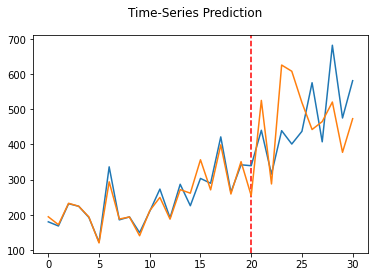

In [12]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()